# Metric Learning

In this practical, we will calculate 2-dimensional embeddings (so that we can easily visualise them) using different approaches: a classification network, a siamese network, and a triplet network. We will use FashionMNIST.

First some preliminary stuff. Apart from typical imports, we define also two functions that will help us later on to generate embeddings for all our data and to plot them in a 2D scatter plot.

In [1]:
import os
import random

import torch
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

## Import data

Import the FashionMNIST data and define datasets and data loaders.

In [3]:
mean, std = 0.28604059698879553, 0.35302424451492237

train_dataset = FashionMNIST('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.4MB/s]


In [4]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

In [5]:
# Set up data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## The Embedding Network

To do the embedding always in the same manner, we will define the embedding part once, and then reuse it with different networks. The embedding we will use is a small CNN architecture, followed by a couple of FC layers that bring down the output to 2 dimensions (so that we can plot the results later).

In [6]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

## Classification Head

The first embedding we will learn is by using a classification head. We define our classification model to use our standard embedding to 2 dimensions, then bring it up to the number of classes (10 in the case if FashionMNIST) and return the logits. We then train it using `torch.nn.CrossEntropyLoss()`.

In [7]:
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        return self.fc1(output)

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [8]:
def train_epoch(train_loader, model, criterion, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        data = data.to(device)

        optimizer.zero_grad()

        outputs = model(data)

        loss = criterion(outputs, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Evaluate on training set
        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 20 == 0:
            print("Iteration {}: Loss = {}".format(batch_idx, loss.item()))

    total_loss /= (batch_idx + 1)
    accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, accuracy

@torch.no_grad()
def test_epoch(val_loader, model, criterion):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        target = target.to(device)
        data = data.to(device)

        outputs = model(data)

        loss = criterion(outputs, target)
        val_loss += loss.item()

        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [9]:
embedding_net = EmbeddingNet().to(device)

n_classes = 10
model = ClassificationNet(embedding_net, n_classes=n_classes)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, last_epoch=-1)

In [10]:
n_epochs = 10 # Do 10 epochs
for epoch in range(n_epochs):

    # Train stage
    train_loss, acc = train_epoch(train_loader, model, criterion, optimizer)

    scheduler.step()
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, train_loss, acc)

    # Validation stage
    val_loss, acc = test_epoch(test_loader, model, criterion)
    val_loss /= len(test_loader)

    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, val_loss, acc)

    print(message)

Iteration 0: Loss = 2.436310291290283
Iteration 20: Loss = 1.9814531803131104
Iteration 40: Loss = 1.6904609203338623
Iteration 60: Loss = 1.6852164268493652
Iteration 80: Loss = 1.571144700050354
Iteration 100: Loss = 1.44632887840271
Iteration 120: Loss = 1.279058814048767
Iteration 140: Loss = 1.2343392372131348
Iteration 160: Loss = 1.1863354444503784
Iteration 180: Loss = 1.1671806573867798
Iteration 200: Loss = 1.1548997163772583
Iteration 220: Loss = 1.026333212852478
Epoch: 1/10. Train set: Average loss: 1.4626 Accuracy: 49.60
Epoch: 1/10. Validation set: Average loss: 1.1217 Accuracy: 61.64
Iteration 0: Loss = 0.8977704644203186
Iteration 20: Loss = 0.9524869918823242
Iteration 40: Loss = 1.0608644485473633
Iteration 60: Loss = 0.9238402247428894
Iteration 80: Loss = 0.9834175705909729
Iteration 100: Loss = 0.9209277629852295
Iteration 120: Loss = 0.7912886142730713
Iteration 140: Loss = 0.8717294931411743
Iteration 160: Loss = 0.9551640748977661
Iteration 180: Loss = 0.855272

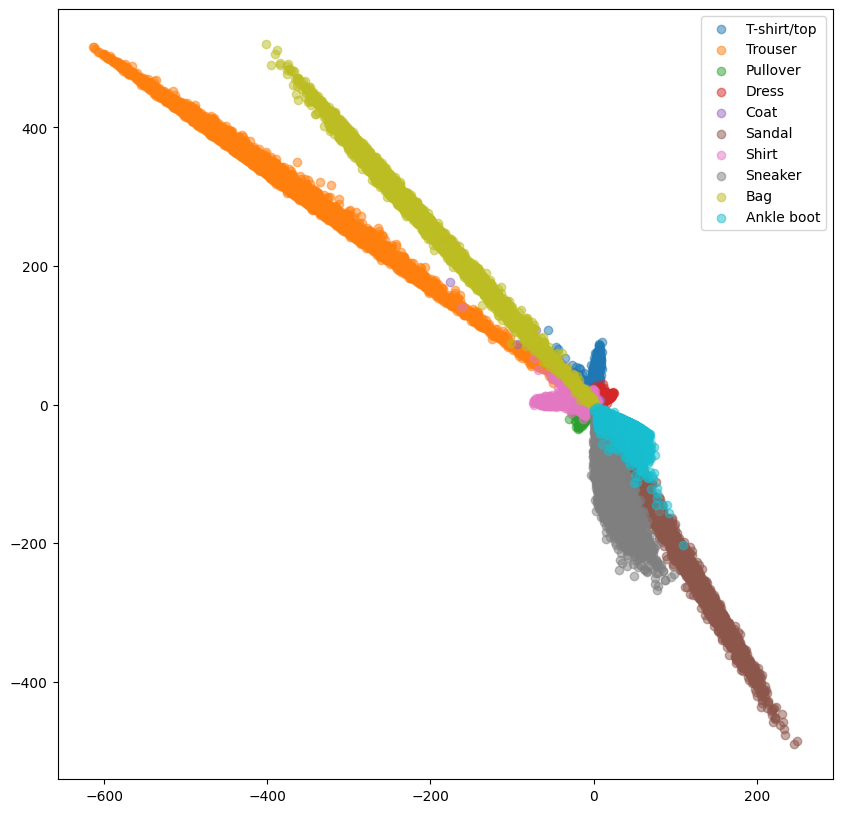

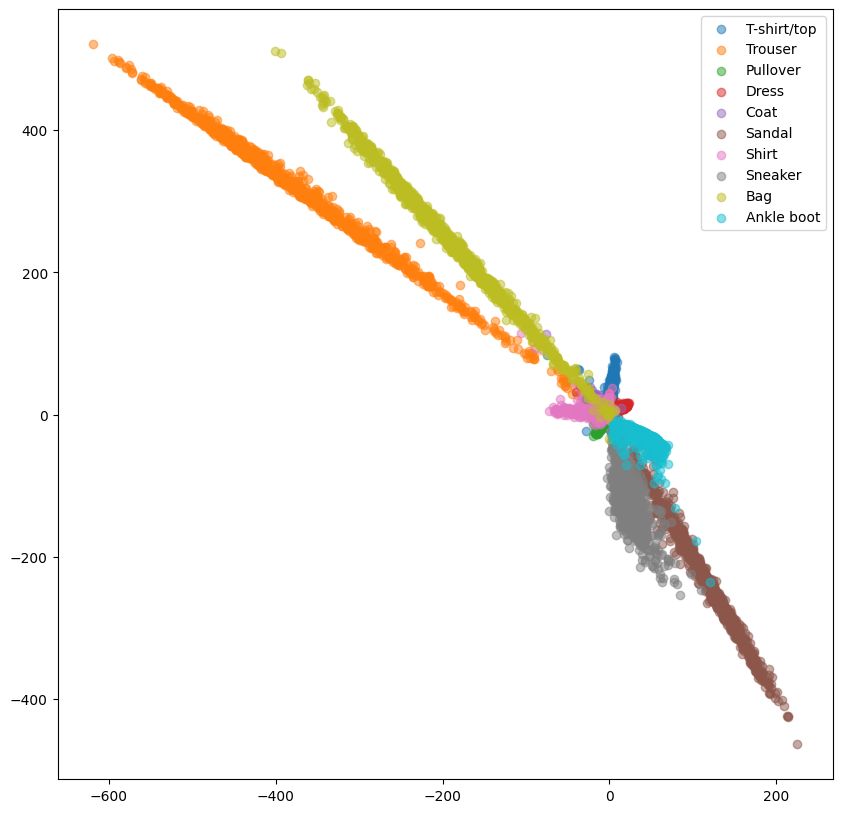

In [11]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Siamese Head

We will repeat the process with a siamese network, but in order to do that we need first to create a different dataset, that creates positive and negative pairs from the original dataset. The pairs will be generated on the fly, randomly, while training. While testing, we will maintain the same pairs always so that comparisons would make sense.

Note that here we just aim to create valid pairs, we do not do any mining (we do not care if they are easy, semi-hard or hard).

In [12]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [13]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train # boolean indicate if it is the training set
        self.transform = self.mnist_dataset.transform

        self.labels = self.mnist_dataset.targets
        self.data = self.mnist_dataset.data
        self.labels_set = set(self.labels.numpy())
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}

        if not self.train:
            # generate fixed pairs for testing once at initialisation
            random_state = np.random.RandomState(29) # Fix random seed for testing

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.labels[i].item()]),
                               1]
                              for i in range(0, len(self.data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            # Generate a positive or negative pair on the fly
            target = np.random.randint(0, 2) # randomly select positive or negative
            img1, label1 = self.data[index], self.labels[index].item()
            if target == 1: # Generate a POSITIVE pair
                siamese_index = index
                while siamese_index == index: # Make sure we do not use ourself as the positive pair
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else: # Generate a NEGATIVE pair
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.data[siamese_index]
        else:
            # Just retrieve the pair from the saved test pairs we generated at init
            img1 = self.data[self.test_pairs[index][0]]
            img2 = self.data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        # Get a PIL image to pass through transform
        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, target


    def __len__(self):
        return len(self.mnist_dataset)

Now we are ready to define our siamese net which just takes in one training sample (which now comprises a pair of images) and embeds them using our embedding function. It returns the two embeddings.

In [14]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

The next thing to do is to define our loss function for the case of the siamese. In this case, we need a function that takes as input TWO vectors and one target that indicates if they are supposed to be a positive pair, or a negative pair, and implements the function:

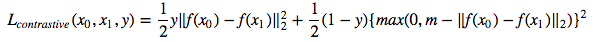

In [15]:
class ContrastiveLoss(nn.Module):
    """
    Max-margin Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        # losses = 0.5 * (target.float() * distances + (1 - target).float() * max(0, self.margin - (distances + self.eps).sqrt()).pow(2)) equivalent to
        losses = 0.5 * (target.float() * distances + (1 - target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

We will also redefine the training and validation loops, as now the data loader gives us 2 samples and the loss function expects 2 samples.

In [16]:
def train_epoch_siamese(train_loader, model, criterion, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(train_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        optimizer.zero_grad()

        output1, output2 = model(data1, data2)

        # The loss is the only thing we can report here
        loss = criterion(output1, output2, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print("Iteration {}: Loss = {}".format(batch_idx, loss.item()))

    total_loss /= (batch_idx + 1)
    return total_loss

@torch.no_grad()
def test_epoch_siamese(val_loader, model, criterion):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(val_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        output1, output2 = model(data1, data2)

        loss = criterion(output1, output2, target)
        val_loss += loss.item()

    return val_loss

In [17]:
siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(test_dataset)   # Note that the train datasets has self.train == True, and the test has self.train == False

batch_size = 256
siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)
siamese_test_loader = DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False)

margin = 1.

embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.to(device)

criterion = ContrastiveLoss(margin)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

In [18]:
n_epochs = 10 # Do 10 epochs
for epoch in range(n_epochs):

        # Train stage
        train_loss = train_epoch_siamese(siamese_train_loader, model, criterion, optimizer)
        scheduler.step()

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)

        # Validation stage
        val_loss = test_epoch_siamese(siamese_test_loader, model, criterion)
        val_loss /= len(siamese_test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, val_loss)

        print(message)

Iteration 0: Loss = 0.22548648715019226
Iteration 20: Loss = 0.06513716280460358
Iteration 40: Loss = 0.05015730857849121
Iteration 60: Loss = 0.06086452305316925
Iteration 80: Loss = 0.03815189749002457
Iteration 100: Loss = 0.052025385200977325
Iteration 120: Loss = 0.04637341573834419
Iteration 140: Loss = 0.04766741022467613
Iteration 160: Loss = 0.0373368002474308
Iteration 180: Loss = 0.04676922783255577
Iteration 200: Loss = 0.03319631889462471
Iteration 220: Loss = 0.0410982221364975
Epoch: 1/10. Train set: Average loss: 0.0527
Epoch: 1/10. Validation set: Average loss: 0.0432
Iteration 0: Loss = 0.040056608617305756
Iteration 20: Loss = 0.044125158339738846
Iteration 40: Loss = 0.04603205621242523
Iteration 60: Loss = 0.04221459478139877
Iteration 80: Loss = 0.044564276933670044
Iteration 100: Loss = 0.036473214626312256
Iteration 120: Loss = 0.03997375816106796
Iteration 140: Loss = 0.04168717563152313
Iteration 160: Loss = 0.034477777779102325
Iteration 180: Loss = 0.0361183

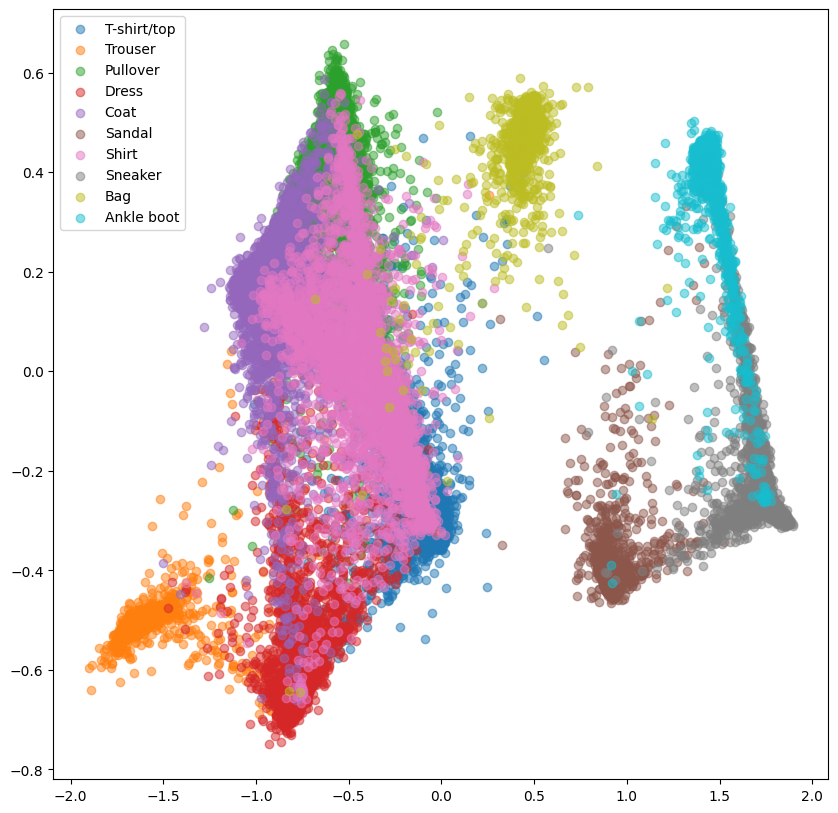

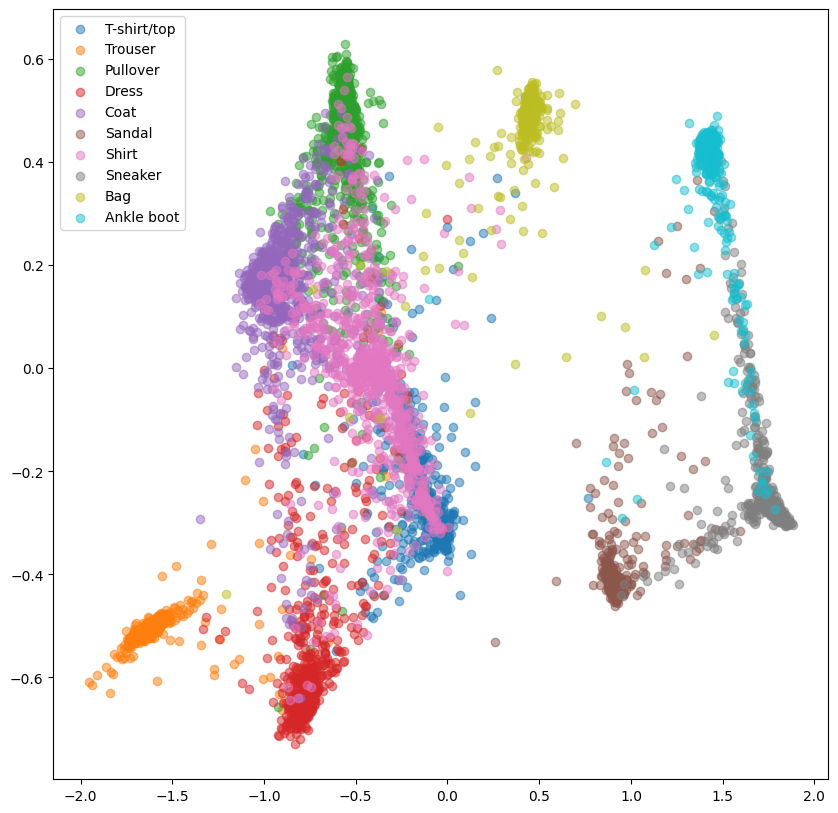

In [19]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

There are couple of problems with siamese and (triplet) networks the way we have implemented them up to this point.

- The number of possible pairs/triplets grows quadratically/cubically with the number of examples. It's infeasible to process them all
- We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with hard examples.
- Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In this case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

## Triplet Loss

We will now train FashionMNIST using a semi-hard Triplet Mining strategy, and visualize the embeddings.

We will not implement any miner, loss or distance function by hand. Instead we will use [The Pytorch Metric Learning Library](https://github.com/KevinMusgrave/pytorch-metric-learning) (installed in the cell below) which implements everything we need.

Check its [docs](https://kevinmusgrave.github.io/pytorch-metric-learning/) so that you get an idea of how to use it.

Install the required packages below. Uncomment the corresponding cell to use the package manager that suits your installation (for Google Colab, that would be pip).

In [20]:
#%conda install -y -c conda-forge pytorch-metric-learning
#%conda install -y -c conda-forge faiss-cpu

In [21]:
%pip install pytorch-metric-learning faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [22]:
from pytorch_metric_learning import losses, miners, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

We will redefine our training and test loops to use this library. The idea is that first we embedd all the data inside our batch. Then we will ask a *Miner* to find good triplets. The list of triplets (a list of tuples with indices) will be passed on to the loss function, that will calculate the loss based on them.

In [23]:
def train(model, loss_func, mining_func, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        embeddings = model(data)

        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)

        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

    return total_loss / (batch_idx + 1)

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(dataloader_num_workers=2)
    return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)

    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(query = train_embeddings, reference = test_embeddings, query_labels = train_labels, reference_labels = test_labels)

    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


We now need to define our miner. Here we will use a `TripletMarginMiner` and cosine similarity to measure the distance between embeddings. We will also use an "accuracy" calculator. The actual metric we will be using is a *precision at 1*, which is just a fancy way to ask whether the 1st nearest neighbour of each sample is of the same class.

https://kevinmusgrave.github.io/pytorch-metric-learning/accuracy_calculation/

In [24]:
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="all")
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

Define the datasets, dataloaders, and the model to use. The model we will use here is just the embedding net on its own.

In [25]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1., distance = distance)

Epoch 1 Iteration 0: Loss = 1.3285566568374634, Number of mined triplets = 978204
Epoch 1 Iteration 20: Loss = 0.9999989867210388, Number of mined triplets = 1511462
Epoch 1 Iteration 40: Loss = 0.9999988079071045, Number of mined triplets = 1487534
Epoch 1 Iteration 60: Loss = 0.9999984502792358, Number of mined triplets = 1476598
Epoch 1 Iteration 80: Loss = 0.9999974966049194, Number of mined triplets = 1472966
Epoch 1 Iteration 100: Loss = 0.9999942183494568, Number of mined triplets = 1513784
Epoch 1 Iteration 120: Loss = 0.9999902248382568, Number of mined triplets = 1475958
Epoch 1 Iteration 140: Loss = 0.9999786615371704, Number of mined triplets = 1469570
Epoch 1 Iteration 160: Loss = 0.999936044216156, Number of mined triplets = 1492562
Epoch 1 Iteration 180: Loss = 0.9995346665382385, Number of mined triplets = 1498472
Epoch 1 Iteration 200: Loss = 0.9875155091285706, Number of mined triplets = 662935
Epoch 1 Iteration 220: Loss = 1.000664234161377, Number of mined triplets 

100%|██████████| 313/313 [00:02<00:00, 108.75it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.44730000000000003
Epoch 2 Iteration 0: Loss = 0.9669498205184937, Number of mined triplets = 542426
Epoch 2 Iteration 20: Loss = 0.9669966101646423, Number of mined triplets = 557072
Epoch 2 Iteration 40: Loss = 0.9800248742103577, Number of mined triplets = 417709
Epoch 2 Iteration 60: Loss = 0.9838317036628723, Number of mined triplets = 384063
Epoch 2 Iteration 80: Loss = 0.9808085560798645, Number of mined triplets = 443703
Epoch 2 Iteration 100: Loss = 1.0015910863876343, Number of mined triplets = 390245
Epoch 2 Iteration 120: Loss = 0.9904730319976807, Number of mined triplets = 359160
Epoch 2 Iteration 140: Loss = 0.9857540726661682, Number of mined triplets = 331568
Epoch 2 Iteration 160: Loss = 1.009071946144104, Number of mined triplets = 422961
Epoch 2 Iteration 180: Loss = 0.9756141901016235, Number of mined triplets = 271521
Epoch 2 Iteration 200: Loss = 1.0272796154022217, Number of mined triplets = 389643
Epoch 2 It

100%|██████████| 313/313 [00:02<00:00, 138.60it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6251833333333333
Epoch 3 Iteration 0: Loss = 1.0286840200424194, Number of mined triplets = 255276
Epoch 3 Iteration 20: Loss = 0.9910992980003357, Number of mined triplets = 366557
Epoch 3 Iteration 40: Loss = 1.01200532913208, Number of mined triplets = 299159
Epoch 3 Iteration 60: Loss = 1.004597544670105, Number of mined triplets = 326119
Epoch 3 Iteration 80: Loss = 0.9605748653411865, Number of mined triplets = 244074
Epoch 3 Iteration 100: Loss = 0.9878530502319336, Number of mined triplets = 389166
Epoch 3 Iteration 120: Loss = 0.9937857389450073, Number of mined triplets = 358568
Epoch 3 Iteration 140: Loss = 0.9807064533233643, Number of mined triplets = 342550
Epoch 3 Iteration 160: Loss = 0.9861974716186523, Number of mined triplets = 367180
Epoch 3 Iteration 180: Loss = 1.021775245666504, Number of mined triplets = 311894
Epoch 3 Iteration 200: Loss = 0.9804414510726929, Number of mined triplets = 225137
Epoch 3 Iterat

100%|██████████| 313/313 [00:02<00:00, 134.37it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6865833333333333
Epoch 4 Iteration 0: Loss = 0.9889937043190002, Number of mined triplets = 298540
Epoch 4 Iteration 20: Loss = 1.000533938407898, Number of mined triplets = 207388
Epoch 4 Iteration 40: Loss = 0.9645703434944153, Number of mined triplets = 284415
Epoch 4 Iteration 60: Loss = 1.0447791814804077, Number of mined triplets = 250030
Epoch 4 Iteration 80: Loss = 1.0388309955596924, Number of mined triplets = 297683
Epoch 4 Iteration 100: Loss = 0.9860714077949524, Number of mined triplets = 220049
Epoch 4 Iteration 120: Loss = 0.9936904907226562, Number of mined triplets = 297754
Epoch 4 Iteration 140: Loss = 0.9867544174194336, Number of mined triplets = 302438
Epoch 4 Iteration 160: Loss = 1.084494948387146, Number of mined triplets = 213600
Epoch 4 Iteration 180: Loss = 1.0024816989898682, Number of mined triplets = 308426
Epoch 4 Iteration 200: Loss = 1.0068246126174927, Number of mined triplets = 210489
Epoch 4 Iter

100%|██████████| 313/313 [00:02<00:00, 136.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7100333333333334
Epoch 5 Iteration 0: Loss = 1.009142279624939, Number of mined triplets = 309442
Epoch 5 Iteration 20: Loss = 0.9977629780769348, Number of mined triplets = 240388
Epoch 5 Iteration 40: Loss = 0.9631434082984924, Number of mined triplets = 213777
Epoch 5 Iteration 60: Loss = 0.9737553596496582, Number of mined triplets = 267992
Epoch 5 Iteration 80: Loss = 0.9712519645690918, Number of mined triplets = 283670
Epoch 5 Iteration 100: Loss = 0.9778762459754944, Number of mined triplets = 179739
Epoch 5 Iteration 120: Loss = 1.0280903577804565, Number of mined triplets = 231505
Epoch 5 Iteration 140: Loss = 0.9518074989318848, Number of mined triplets = 195588
Epoch 5 Iteration 160: Loss = 0.9638844132423401, Number of mined triplets = 217176
Epoch 5 Iteration 180: Loss = 1.0075552463531494, Number of mined triplets = 190389
Epoch 5 Iteration 200: Loss = 0.9853644967079163, Number of mined triplets = 218311
Epoch 5 Ite

100%|██████████| 313/313 [00:02<00:00, 139.73it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7415666666666667
Epoch 6 Iteration 0: Loss = 0.9956958889961243, Number of mined triplets = 230306
Epoch 6 Iteration 20: Loss = 0.9622030258178711, Number of mined triplets = 224434
Epoch 6 Iteration 40: Loss = 1.0330787897109985, Number of mined triplets = 220043
Epoch 6 Iteration 60: Loss = 0.9685280919075012, Number of mined triplets = 254480
Epoch 6 Iteration 80: Loss = 1.0023113489151, Number of mined triplets = 240898
Epoch 6 Iteration 100: Loss = 0.964015007019043, Number of mined triplets = 200295
Epoch 6 Iteration 120: Loss = 1.0233967304229736, Number of mined triplets = 335333
Epoch 6 Iteration 140: Loss = 0.9878626465797424, Number of mined triplets = 231808
Epoch 6 Iteration 160: Loss = 0.9749927520751953, Number of mined triplets = 234871
Epoch 6 Iteration 180: Loss = 0.9652612209320068, Number of mined triplets = 194206
Epoch 6 Iteration 200: Loss = 0.9796385765075684, Number of mined triplets = 253405
Epoch 6 Iterat

100%|██████████| 313/313 [00:02<00:00, 111.93it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7523000000000001
Epoch 7 Iteration 0: Loss = 0.9796368479728699, Number of mined triplets = 218996
Epoch 7 Iteration 20: Loss = 1.0338743925094604, Number of mined triplets = 200710
Epoch 7 Iteration 40: Loss = 0.9688976407051086, Number of mined triplets = 240150
Epoch 7 Iteration 60: Loss = 0.9813034534454346, Number of mined triplets = 331258
Epoch 7 Iteration 80: Loss = 0.974976658821106, Number of mined triplets = 250841
Epoch 7 Iteration 100: Loss = 0.9811789989471436, Number of mined triplets = 185122
Epoch 7 Iteration 120: Loss = 0.9733496904373169, Number of mined triplets = 394417
Epoch 7 Iteration 140: Loss = 1.017371654510498, Number of mined triplets = 313403
Epoch 7 Iteration 160: Loss = 0.9708826541900635, Number of mined triplets = 275523
Epoch 7 Iteration 180: Loss = 1.036981225013733, Number of mined triplets = 237501
Epoch 7 Iteration 200: Loss = 0.9663022756576538, Number of mined triplets = 227013
Epoch 7 Itera

100%|██████████| 313/313 [00:02<00:00, 138.58it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7524166666666667
Epoch 8 Iteration 0: Loss = 1.0489267110824585, Number of mined triplets = 287697
Epoch 8 Iteration 20: Loss = 0.9918665885925293, Number of mined triplets = 276921
Epoch 8 Iteration 40: Loss = 0.9767215847969055, Number of mined triplets = 216421
Epoch 8 Iteration 60: Loss = 0.9927159547805786, Number of mined triplets = 172809
Epoch 8 Iteration 80: Loss = 1.077263355255127, Number of mined triplets = 207466
Epoch 8 Iteration 100: Loss = 0.9662278890609741, Number of mined triplets = 202383
Epoch 8 Iteration 120: Loss = 0.993787407875061, Number of mined triplets = 229346
Epoch 8 Iteration 140: Loss = 1.0478755235671997, Number of mined triplets = 172930
Epoch 8 Iteration 160: Loss = 0.9893410205841064, Number of mined triplets = 192772
Epoch 8 Iteration 180: Loss = 0.9739686846733093, Number of mined triplets = 193212
Epoch 8 Iteration 200: Loss = 0.9831915497779846, Number of mined triplets = 182267
Epoch 8 Iter

100%|██████████| 313/313 [00:02<00:00, 105.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7561833333333333
Epoch 9 Iteration 0: Loss = 0.9756655097007751, Number of mined triplets = 197856
Epoch 9 Iteration 20: Loss = 1.0436004400253296, Number of mined triplets = 236103
Epoch 9 Iteration 40: Loss = 0.9770997762680054, Number of mined triplets = 189567
Epoch 9 Iteration 60: Loss = 1.0550016164779663, Number of mined triplets = 185573
Epoch 9 Iteration 80: Loss = 0.9958178997039795, Number of mined triplets = 210250
Epoch 9 Iteration 100: Loss = 0.9899093508720398, Number of mined triplets = 205618
Epoch 9 Iteration 120: Loss = 1.0087025165557861, Number of mined triplets = 191052
Epoch 9 Iteration 140: Loss = 0.9972994923591614, Number of mined triplets = 212543
Epoch 9 Iteration 160: Loss = 0.9984484314918518, Number of mined triplets = 248748
Epoch 9 Iteration 180: Loss = 0.9873771071434021, Number of mined triplets = 196300
Epoch 9 Iteration 200: Loss = 0.9659110307693481, Number of mined triplets = 274141
Epoch 9 It

100%|██████████| 313/313 [00:02<00:00, 135.80it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7762
Epoch 10 Iteration 0: Loss = 0.9494644403457642, Number of mined triplets = 147278
Epoch 10 Iteration 20: Loss = 0.950080156326294, Number of mined triplets = 134027
Epoch 10 Iteration 40: Loss = 1.0349379777908325, Number of mined triplets = 214512
Epoch 10 Iteration 60: Loss = 0.9597131013870239, Number of mined triplets = 201407
Epoch 10 Iteration 80: Loss = 0.9866700172424316, Number of mined triplets = 195532
Epoch 10 Iteration 100: Loss = 0.9645976424217224, Number of mined triplets = 238281
Epoch 10 Iteration 120: Loss = 0.9714757800102234, Number of mined triplets = 253010
Epoch 10 Iteration 140: Loss = 0.9703587293624878, Number of mined triplets = 158970
Epoch 10 Iteration 160: Loss = 0.9593543410301208, Number of mined triplets = 206673
Epoch 10 Iteration 180: Loss = 1.0047504901885986, Number of mined triplets = 151070
Epoch 10 Iteration 200: Loss = 0.9733496308326721, Number of mined triplets = 191005
Epoch 10 Ite

100%|██████████| 313/313 [00:02<00:00, 137.43it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7751333333333333


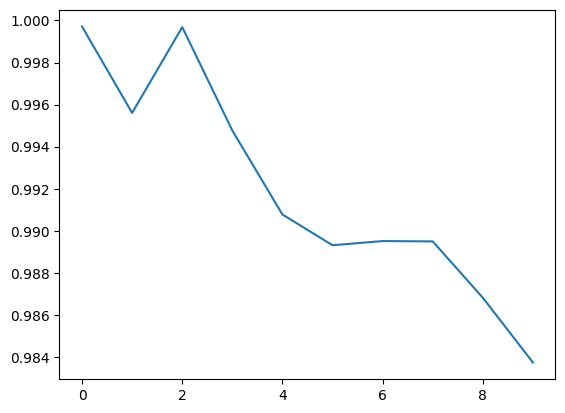

In [26]:
num_epochs = 10
loss_evolution = []

for epoch in range(1, num_epochs + 1):
    loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution.append(loss)
    test(train_dataset, test_dataset, model, accuracy_calculator)

plt.plot(loss_evolution)
plt.show()

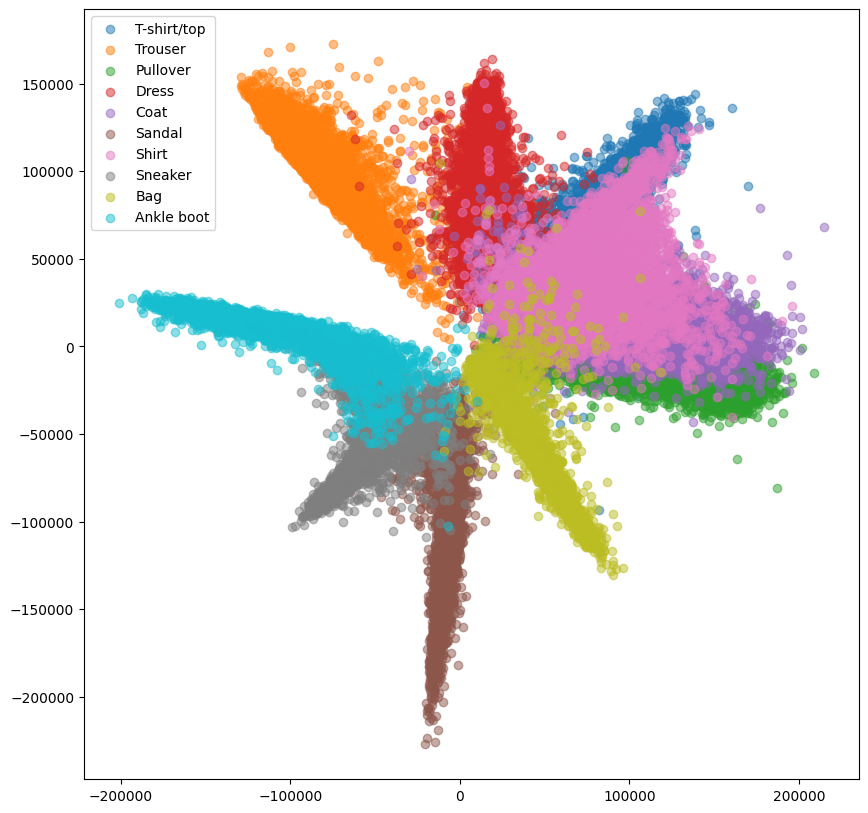

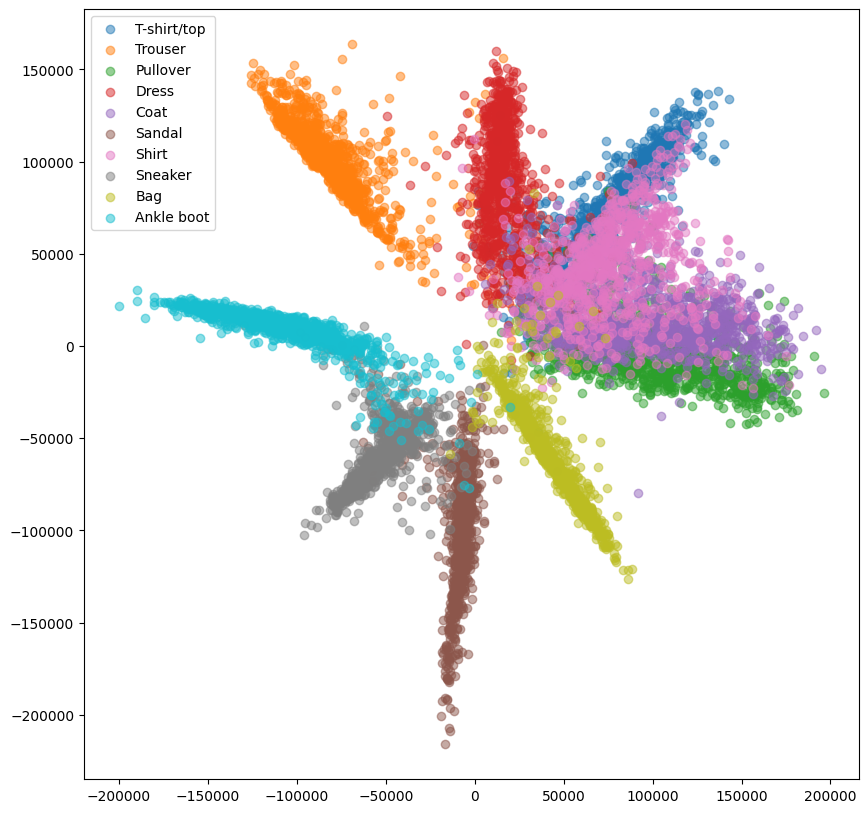

In [27]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Better Mining

<br>
<span style="color:blue">

**Exercise 1**: Explain the difference between semi-hard, easy and hard triplets. Try training with each type of triplets mentioned above separately and comment on the effect they have on training, using loss curves and other evidence you find necessary.
    
</span>

In [28]:
#Your Code Here


Epoch 1 Iteration 0: Loss = 0.5402202010154724, Number of mined triplets = 466968
Epoch 1 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 142.20it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.18953333333333333
Epoch 2 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 134.34it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.18953333333333333
Epoch 3 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 135.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.18953333333333333
Epoch 4 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 139.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.18953333333333333
Epoch 5 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 111.46it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.18953333333333333
Epoch 6 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 136.42it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.18953333333333333
Epoch 7 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 119.90it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.18953333333333333
Epoch 8 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 141.50it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.18953333333333333
Epoch 9 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 134.83it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.18953333333333333
Epoch 10 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 128.89it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.18953333333333333
Epoch 1 Iteration 0: Loss = 1.0001165866851807, Number of mined triplets = 504786
Epoch 1 Iteration 20: Loss = 1.000002145767212, Number of mined triplets = 529617
Epoch 1 Iteration 40: Loss = 1.0000008344650269, Number of mined triplets = 394642
Epoch 1 Iteration 60: Loss = 1.0000003576278687, Number of mined triplets = 441215
Epoch 1 Iteration 80: Loss = 1.000000238418579, Number of mined triplets = 414475
Epoch 1 Iteration 100: Loss = 1.000000238418579, Number of mined triplets = 453415
Epoch 1 Iteration 120: Loss = 1.000000238418579, Number of mined triplets = 453746
Epoch 1 Iteration 140: Loss = 1.000000238418579, Number of mined triplets = 424361
Epoch 1 Iteration 160: Loss = 1.0000001192092896, Number of mined triplets = 450926
Epoch 1 Iteration 180: Loss = 1.0000001192092896, Number of mined triplets = 399553
Epoch 1 Iteration 200: Loss = 0.9999999403953552, Number of mined triplets = 495668
Epoch 1 Iterat

100%|██████████| 313/313 [00:02<00:00, 137.11it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.23470000000000002
Epoch 2 Iteration 0: Loss = 1.0000001192092896, Number of mined triplets = 483202
Epoch 2 Iteration 20: Loss = 0.9999999403953552, Number of mined triplets = 410376
Epoch 2 Iteration 40: Loss = 1.0, Number of mined triplets = 466531
Epoch 2 Iteration 60: Loss = 1.0, Number of mined triplets = 451637
Epoch 2 Iteration 80: Loss = 1.0, Number of mined triplets = 490211
Epoch 2 Iteration 100: Loss = 1.0, Number of mined triplets = 472670
Epoch 2 Iteration 120: Loss = 1.0, Number of mined triplets = 478461
Epoch 2 Iteration 140: Loss = 1.0, Number of mined triplets = 442438
Epoch 2 Iteration 160: Loss = 1.0, Number of mined triplets = 451618
Epoch 2 Iteration 180: Loss = 1.0, Number of mined triplets = 484018
Epoch 2 Iteration 200: Loss = 1.0, Number of mined triplets = 447929
Epoch 2 Iteration 220: Loss = 0.9999999403953552, Number of mined triplets = 500682


100%|██████████| 313/313 [00:02<00:00, 106.81it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2613166666666667
Epoch 3 Iteration 0: Loss = 1.0, Number of mined triplets = 520962
Epoch 3 Iteration 20: Loss = 1.0, Number of mined triplets = 509699
Epoch 3 Iteration 40: Loss = 1.0, Number of mined triplets = 459123
Epoch 3 Iteration 60: Loss = 1.0, Number of mined triplets = 556241
Epoch 3 Iteration 80: Loss = 1.0, Number of mined triplets = 548382
Epoch 3 Iteration 100: Loss = 1.0, Number of mined triplets = 524697
Epoch 3 Iteration 120: Loss = 1.0, Number of mined triplets = 469897
Epoch 3 Iteration 140: Loss = 1.0, Number of mined triplets = 486121
Epoch 3 Iteration 160: Loss = 1.0, Number of mined triplets = 494009
Epoch 3 Iteration 180: Loss = 1.0, Number of mined triplets = 532318
Epoch 3 Iteration 200: Loss = 1.0, Number of mined triplets = 438359
Epoch 3 Iteration 220: Loss = 1.0, Number of mined triplets = 459475


100%|██████████| 313/313 [00:02<00:00, 137.14it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.26543333333333335
Epoch 4 Iteration 0: Loss = 1.0, Number of mined triplets = 556985
Epoch 4 Iteration 20: Loss = 1.0, Number of mined triplets = 433535
Epoch 4 Iteration 40: Loss = 1.0, Number of mined triplets = 441746
Epoch 4 Iteration 60: Loss = 0.9999999403953552, Number of mined triplets = 481355
Epoch 4 Iteration 80: Loss = 1.0, Number of mined triplets = 452288
Epoch 4 Iteration 100: Loss = 0.9999999403953552, Number of mined triplets = 443848
Epoch 4 Iteration 120: Loss = 1.0, Number of mined triplets = 511010
Epoch 4 Iteration 140: Loss = 1.0, Number of mined triplets = 460396
Epoch 4 Iteration 160: Loss = 1.0, Number of mined triplets = 469991
Epoch 4 Iteration 180: Loss = 1.0, Number of mined triplets = 487299
Epoch 4 Iteration 200: Loss = 0.9999999403953552, Number of mined triplets = 508683
Epoch 4 Iteration 220: Loss = 1.0, Number of mined triplets = 445677


100%|██████████| 313/313 [00:03<00:00, 101.59it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.28218333333333334
Epoch 5 Iteration 0: Loss = 1.0, Number of mined triplets = 507262
Epoch 5 Iteration 20: Loss = 1.0, Number of mined triplets = 471083
Epoch 5 Iteration 40: Loss = 1.0, Number of mined triplets = 440896
Epoch 5 Iteration 60: Loss = 0.9999999403953552, Number of mined triplets = 423434
Epoch 5 Iteration 80: Loss = 1.0, Number of mined triplets = 431287
Epoch 5 Iteration 100: Loss = 1.0, Number of mined triplets = 445041
Epoch 5 Iteration 120: Loss = 1.0, Number of mined triplets = 484209
Epoch 5 Iteration 140: Loss = 1.0, Number of mined triplets = 454797
Epoch 5 Iteration 160: Loss = 1.0, Number of mined triplets = 538448
Epoch 5 Iteration 180: Loss = 0.9999999403953552, Number of mined triplets = 472498
Epoch 5 Iteration 200: Loss = 1.0, Number of mined triplets = 468141
Epoch 5 Iteration 220: Loss = 0.9999999403953552, Number of mined triplets = 516676


100%|██████████| 313/313 [00:02<00:00, 137.14it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.28805000000000003
Epoch 6 Iteration 0: Loss = 1.0, Number of mined triplets = 439615
Epoch 6 Iteration 20: Loss = 1.0, Number of mined triplets = 434553
Epoch 6 Iteration 40: Loss = 1.0, Number of mined triplets = 484789
Epoch 6 Iteration 60: Loss = 1.0, Number of mined triplets = 507561
Epoch 6 Iteration 80: Loss = 1.0, Number of mined triplets = 505813
Epoch 6 Iteration 100: Loss = 1.0, Number of mined triplets = 500148
Epoch 6 Iteration 120: Loss = 1.0, Number of mined triplets = 434445
Epoch 6 Iteration 140: Loss = 1.0, Number of mined triplets = 467383
Epoch 6 Iteration 160: Loss = 1.0, Number of mined triplets = 480118
Epoch 6 Iteration 180: Loss = 1.0, Number of mined triplets = 414936
Epoch 6 Iteration 200: Loss = 1.0, Number of mined triplets = 440759
Epoch 6 Iteration 220: Loss = 1.0, Number of mined triplets = 570395


100%|██████████| 313/313 [00:03<00:00, 103.59it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2888833333333333
Epoch 7 Iteration 0: Loss = 1.0, Number of mined triplets = 503275
Epoch 7 Iteration 20: Loss = 1.0, Number of mined triplets = 414849
Epoch 7 Iteration 40: Loss = 1.0, Number of mined triplets = 457111
Epoch 7 Iteration 60: Loss = 1.0, Number of mined triplets = 394195
Epoch 7 Iteration 80: Loss = 1.0, Number of mined triplets = 432036
Epoch 7 Iteration 100: Loss = 1.0, Number of mined triplets = 427180
Epoch 7 Iteration 120: Loss = 0.9999999403953552, Number of mined triplets = 478394
Epoch 7 Iteration 140: Loss = 1.0, Number of mined triplets = 469237
Epoch 7 Iteration 160: Loss = 1.0, Number of mined triplets = 388764
Epoch 7 Iteration 180: Loss = 1.0, Number of mined triplets = 499150
Epoch 7 Iteration 200: Loss = 1.0, Number of mined triplets = 451563
Epoch 7 Iteration 220: Loss = 1.0, Number of mined triplets = 484843


100%|██████████| 313/313 [00:02<00:00, 138.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.30078333333333335
Epoch 8 Iteration 0: Loss = 0.9999999403953552, Number of mined triplets = 491482
Epoch 8 Iteration 20: Loss = 1.0, Number of mined triplets = 468889
Epoch 8 Iteration 40: Loss = 1.0, Number of mined triplets = 483755
Epoch 8 Iteration 60: Loss = 1.0, Number of mined triplets = 510843
Epoch 8 Iteration 80: Loss = 0.9999999403953552, Number of mined triplets = 397447
Epoch 8 Iteration 100: Loss = 0.9999999403953552, Number of mined triplets = 392760
Epoch 8 Iteration 120: Loss = 0.9999999403953552, Number of mined triplets = 423543
Epoch 8 Iteration 140: Loss = 1.0, Number of mined triplets = 443586
Epoch 8 Iteration 160: Loss = 0.9999999403953552, Number of mined triplets = 478971
Epoch 8 Iteration 180: Loss = 0.9999999403953552, Number of mined triplets = 434944
Epoch 8 Iteration 200: Loss = 1.0, Number of mined triplets = 415089
Epoch 8 Iteration 220: Loss = 1.0, Number of mined triplets = 460819


100%|██████████| 313/313 [00:02<00:00, 132.11it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.25978333333333337
Epoch 9 Iteration 0: Loss = 1.0, Number of mined triplets = 414641
Epoch 9 Iteration 20: Loss = 1.0, Number of mined triplets = 428452
Epoch 9 Iteration 40: Loss = 1.0, Number of mined triplets = 377081
Epoch 9 Iteration 60: Loss = 1.0, Number of mined triplets = 500518
Epoch 9 Iteration 80: Loss = 1.0, Number of mined triplets = 434979
Epoch 9 Iteration 100: Loss = 1.0, Number of mined triplets = 397653
Epoch 9 Iteration 120: Loss = 1.0, Number of mined triplets = 417179
Epoch 9 Iteration 140: Loss = 1.0, Number of mined triplets = 357744
Epoch 9 Iteration 160: Loss = 1.0, Number of mined triplets = 423738
Epoch 9 Iteration 180: Loss = 0.9999999403953552, Number of mined triplets = 410592
Epoch 9 Iteration 200: Loss = 0.9999999403953552, Number of mined triplets = 491010
Epoch 9 Iteration 220: Loss = 1.0, Number of mined triplets = 432754


100%|██████████| 313/313 [00:02<00:00, 136.37it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3035666666666667
Epoch 10 Iteration 0: Loss = 0.9999999403953552, Number of mined triplets = 495037
Epoch 10 Iteration 20: Loss = 1.0, Number of mined triplets = 467387
Epoch 10 Iteration 40: Loss = 1.0, Number of mined triplets = 448386
Epoch 10 Iteration 60: Loss = 1.0, Number of mined triplets = 457580
Epoch 10 Iteration 80: Loss = 1.0, Number of mined triplets = 424518
Epoch 10 Iteration 100: Loss = 1.0, Number of mined triplets = 428760
Epoch 10 Iteration 120: Loss = 0.9999999403953552, Number of mined triplets = 419053
Epoch 10 Iteration 140: Loss = 0.9999999403953552, Number of mined triplets = 497685
Epoch 10 Iteration 160: Loss = 1.0, Number of mined triplets = 399072
Epoch 10 Iteration 180: Loss = 1.0, Number of mined triplets = 517904
Epoch 10 Iteration 200: Loss = 1.0, Number of mined triplets = 407310
Epoch 10 Iteration 220: Loss = 1.0, Number of mined triplets = 401869


100%|██████████| 313/313 [00:02<00:00, 138.40it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3158166666666667
Epoch 1 Iteration 0: Loss = 0.9999995827674866, Number of mined triplets = 1055186
Epoch 1 Iteration 20: Loss = 0.9997490048408508, Number of mined triplets = 1059913
Epoch 1 Iteration 40: Loss = 0.9249964356422424, Number of mined triplets = 278642
Epoch 1 Iteration 60: Loss = 0.9276406764984131, Number of mined triplets = 147074
Epoch 1 Iteration 80: Loss = 0.919666588306427, Number of mined triplets = 162061
Epoch 1 Iteration 100: Loss = 0.9178885817527771, Number of mined triplets = 138019
Epoch 1 Iteration 120: Loss = 0.919037401676178, Number of mined triplets = 144031
Epoch 1 Iteration 140: Loss = 0.91481614112854, Number of mined triplets = 152241
Epoch 1 Iteration 160: Loss = 0.9149370193481445, Number of mined triplets = 126211
Epoch 1 Iteration 180: Loss = 0.9089129567146301, Number of mined triplets = 156629
Epoch 1 Iteration 200: Loss = 0.9197238087654114, Number of mined triplets = 160225
Epoch 1 Iter

100%|██████████| 313/313 [00:02<00:00, 137.59it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6369666666666667
Epoch 2 Iteration 0: Loss = 0.8955385088920593, Number of mined triplets = 139428
Epoch 2 Iteration 20: Loss = 0.9015096426010132, Number of mined triplets = 158156
Epoch 2 Iteration 40: Loss = 0.8955050706863403, Number of mined triplets = 147863
Epoch 2 Iteration 60: Loss = 0.8982393145561218, Number of mined triplets = 139176
Epoch 2 Iteration 80: Loss = 0.9068820476531982, Number of mined triplets = 167690
Epoch 2 Iteration 100: Loss = 0.8935737609863281, Number of mined triplets = 123089
Epoch 2 Iteration 120: Loss = 0.89436936378479, Number of mined triplets = 151899
Epoch 2 Iteration 140: Loss = 0.8900396227836609, Number of mined triplets = 147339
Epoch 2 Iteration 160: Loss = 0.8893274664878845, Number of mined triplets = 142959
Epoch 2 Iteration 180: Loss = 0.8893324732780457, Number of mined triplets = 122255
Epoch 2 Iteration 200: Loss = 0.8890067338943481, Number of mined triplets = 117048
Epoch 2 Iter

100%|██████████| 313/313 [00:02<00:00, 137.28it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7240500000000001
Epoch 3 Iteration 0: Loss = 0.8952382802963257, Number of mined triplets = 136051
Epoch 3 Iteration 20: Loss = 0.8840664029121399, Number of mined triplets = 139266
Epoch 3 Iteration 40: Loss = 0.8951290249824524, Number of mined triplets = 155947
Epoch 3 Iteration 60: Loss = 0.8845197558403015, Number of mined triplets = 155535
Epoch 3 Iteration 80: Loss = 0.8982899785041809, Number of mined triplets = 145158
Epoch 3 Iteration 100: Loss = 0.8801504373550415, Number of mined triplets = 135767
Epoch 3 Iteration 120: Loss = 0.8902959823608398, Number of mined triplets = 135315
Epoch 3 Iteration 140: Loss = 0.8892449736595154, Number of mined triplets = 122900
Epoch 3 Iteration 160: Loss = 0.8836703300476074, Number of mined triplets = 127920
Epoch 3 Iteration 180: Loss = 0.8778930306434631, Number of mined triplets = 153323
Epoch 3 Iteration 200: Loss = 0.8764334917068481, Number of mined triplets = 137565
Epoch 3 It

100%|██████████| 313/313 [00:02<00:00, 106.05it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7471333333333333
Epoch 4 Iteration 0: Loss = 0.879343569278717, Number of mined triplets = 111977
Epoch 4 Iteration 20: Loss = 0.9063239097595215, Number of mined triplets = 127078
Epoch 4 Iteration 40: Loss = 0.8815176486968994, Number of mined triplets = 151718
Epoch 4 Iteration 60: Loss = 0.900072455406189, Number of mined triplets = 121740
Epoch 4 Iteration 80: Loss = 0.8814436793327332, Number of mined triplets = 121659
Epoch 4 Iteration 100: Loss = 0.8804793357849121, Number of mined triplets = 144316
Epoch 4 Iteration 120: Loss = 0.8947408199310303, Number of mined triplets = 134389
Epoch 4 Iteration 140: Loss = 0.8846529722213745, Number of mined triplets = 122372
Epoch 4 Iteration 160: Loss = 0.8917281627655029, Number of mined triplets = 119968
Epoch 4 Iteration 180: Loss = 0.8948107361793518, Number of mined triplets = 126923
Epoch 4 Iteration 200: Loss = 0.8917966485023499, Number of mined triplets = 130666
Epoch 4 Iter

100%|██████████| 313/313 [00:02<00:00, 138.33it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7707333333333334
Epoch 5 Iteration 0: Loss = 0.8983147740364075, Number of mined triplets = 106883
Epoch 5 Iteration 20: Loss = 0.8959534764289856, Number of mined triplets = 99527
Epoch 5 Iteration 40: Loss = 0.8874937295913696, Number of mined triplets = 112815
Epoch 5 Iteration 60: Loss = 0.8880637288093567, Number of mined triplets = 129392
Epoch 5 Iteration 80: Loss = 0.8800032138824463, Number of mined triplets = 103337
Epoch 5 Iteration 100: Loss = 0.8723281621932983, Number of mined triplets = 121715
Epoch 5 Iteration 120: Loss = 0.8984497785568237, Number of mined triplets = 145142
Epoch 5 Iteration 140: Loss = 0.8911195397377014, Number of mined triplets = 110234
Epoch 5 Iteration 160: Loss = 0.8815600275993347, Number of mined triplets = 136369
Epoch 5 Iteration 180: Loss = 0.8824832439422607, Number of mined triplets = 120398
Epoch 5 Iteration 200: Loss = 0.8874126672744751, Number of mined triplets = 103265
Epoch 5 Ite

100%|██████████| 313/313 [00:03<00:00, 102.78it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7836833333333334
Epoch 6 Iteration 0: Loss = 0.8934295773506165, Number of mined triplets = 101080
Epoch 6 Iteration 20: Loss = 0.8901573419570923, Number of mined triplets = 129334
Epoch 6 Iteration 40: Loss = 0.8802741765975952, Number of mined triplets = 130975
Epoch 6 Iteration 60: Loss = 0.8862605094909668, Number of mined triplets = 87960
Epoch 6 Iteration 80: Loss = 0.8750410676002502, Number of mined triplets = 100812
Epoch 6 Iteration 100: Loss = 0.8729163408279419, Number of mined triplets = 126184
Epoch 6 Iteration 120: Loss = 0.8748533129692078, Number of mined triplets = 119322
Epoch 6 Iteration 140: Loss = 0.8846901059150696, Number of mined triplets = 121752
Epoch 6 Iteration 160: Loss = 0.8870832920074463, Number of mined triplets = 118510
Epoch 6 Iteration 180: Loss = 0.8863818645477295, Number of mined triplets = 105796
Epoch 6 Iteration 200: Loss = 0.872819721698761, Number of mined triplets = 116383
Epoch 6 Iter

100%|██████████| 313/313 [00:02<00:00, 137.49it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7985
Epoch 7 Iteration 0: Loss = 0.8936147689819336, Number of mined triplets = 113221
Epoch 7 Iteration 20: Loss = 0.894482433795929, Number of mined triplets = 106354
Epoch 7 Iteration 40: Loss = 0.8880588412284851, Number of mined triplets = 110641
Epoch 7 Iteration 60: Loss = 0.8879762887954712, Number of mined triplets = 108693
Epoch 7 Iteration 80: Loss = 0.8845260739326477, Number of mined triplets = 95616
Epoch 7 Iteration 100: Loss = 0.8746732473373413, Number of mined triplets = 126479
Epoch 7 Iteration 120: Loss = 0.881812334060669, Number of mined triplets = 102177
Epoch 7 Iteration 140: Loss = 0.8603278994560242, Number of mined triplets = 144036
Epoch 7 Iteration 160: Loss = 0.8764989376068115, Number of mined triplets = 100628
Epoch 7 Iteration 180: Loss = 0.8768324255943298, Number of mined triplets = 114707
Epoch 7 Iteration 200: Loss = 0.8772501945495605, Number of mined triplets = 117752
Epoch 7 Iteration 220: Lo

100%|██████████| 313/313 [00:02<00:00, 128.68it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8057000000000001
Epoch 8 Iteration 0: Loss = 0.8892337679862976, Number of mined triplets = 119012
Epoch 8 Iteration 20: Loss = 0.8680075407028198, Number of mined triplets = 102931
Epoch 8 Iteration 40: Loss = 0.867689311504364, Number of mined triplets = 110551
Epoch 8 Iteration 60: Loss = 0.8684276938438416, Number of mined triplets = 117485
Epoch 8 Iteration 80: Loss = 0.894750714302063, Number of mined triplets = 109204
Epoch 8 Iteration 100: Loss = 0.8814432621002197, Number of mined triplets = 128101
Epoch 8 Iteration 120: Loss = 0.8681170344352722, Number of mined triplets = 102658
Epoch 8 Iteration 140: Loss = 0.8759633302688599, Number of mined triplets = 107571
Epoch 8 Iteration 160: Loss = 0.8839926719665527, Number of mined triplets = 90808
Epoch 8 Iteration 180: Loss = 0.8741251826286316, Number of mined triplets = 111643
Epoch 8 Iteration 200: Loss = 0.885232150554657, Number of mined triplets = 163048
Epoch 8 Iterat

100%|██████████| 313/313 [00:02<00:00, 137.70it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8163833333333333
Epoch 9 Iteration 0: Loss = 0.8695168495178223, Number of mined triplets = 129438
Epoch 9 Iteration 20: Loss = 0.8512172698974609, Number of mined triplets = 118843
Epoch 9 Iteration 40: Loss = 0.8685394525527954, Number of mined triplets = 89961
Epoch 9 Iteration 60: Loss = 0.8822588324546814, Number of mined triplets = 115810
Epoch 9 Iteration 80: Loss = 0.8724591135978699, Number of mined triplets = 110266
Epoch 9 Iteration 100: Loss = 0.8818307518959045, Number of mined triplets = 108810
Epoch 9 Iteration 120: Loss = 0.8799100518226624, Number of mined triplets = 126902
Epoch 9 Iteration 140: Loss = 0.8667972683906555, Number of mined triplets = 137771
Epoch 9 Iteration 160: Loss = 0.8750813603401184, Number of mined triplets = 85286
Epoch 9 Iteration 180: Loss = 0.8875446319580078, Number of mined triplets = 123079
Epoch 9 Iteration 200: Loss = 0.8890233039855957, Number of mined triplets = 102114
Epoch 9 Iter

100%|██████████| 313/313 [00:02<00:00, 138.19it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8125666666666667
Epoch 10 Iteration 0: Loss = 0.8823357224464417, Number of mined triplets = 102272
Epoch 10 Iteration 20: Loss = 0.874384880065918, Number of mined triplets = 124778
Epoch 10 Iteration 40: Loss = 0.867520272731781, Number of mined triplets = 111054
Epoch 10 Iteration 60: Loss = 0.8843585848808289, Number of mined triplets = 93303
Epoch 10 Iteration 80: Loss = 0.8718552589416504, Number of mined triplets = 118756
Epoch 10 Iteration 100: Loss = 0.8642272353172302, Number of mined triplets = 128232
Epoch 10 Iteration 120: Loss = 0.8842165470123291, Number of mined triplets = 104782
Epoch 10 Iteration 140: Loss = 0.8778132200241089, Number of mined triplets = 137869
Epoch 10 Iteration 160: Loss = 0.8667079210281372, Number of mined triplets = 148912
Epoch 10 Iteration 180: Loss = 0.8661648035049438, Number of mined triplets = 98626
Epoch 10 Iteration 200: Loss = 0.8740804195404053, Number of mined triplets = 88814
Epoc

100%|██████████| 313/313 [00:02<00:00, 135.96it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8218166666666668


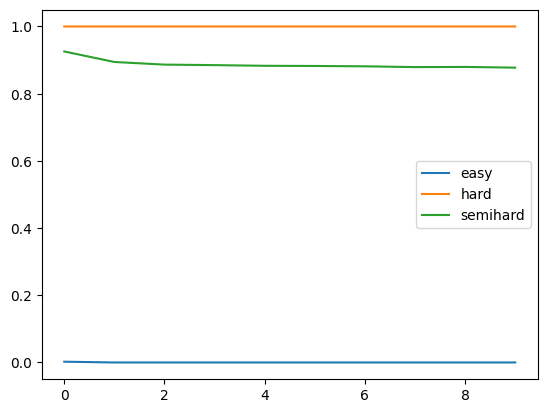

In [29]:
# SOLUTION

model = EmbeddingNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

for triplet in ["easy", "hard", "semihard"]:
    mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets=triplet)
    loss_evolution = []
    for epoch in range(1, num_epochs + 1):
        loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
        loss_evolution.append(loss)
        test(train_dataset, test_dataset, model, accuracy_calculator)

    plt.plot(loss_evolution, label=triplet)
plt.legend()
plt.show()

<br>
<span style="color:blue">

**Exercise 2**: Read the documentation of the PyTorch Metric Learning library and try a couple of different mining strategies, distances, margins and loss functions.
    
</span>

In [30]:
# Your Code Here


## Better embeddings

<br>
<span style="color:blue">

**Exercise 3**: Train a new (preferably more powerful) network with a 128-dimensional embedding, visualize the embedding using T-SNE.

We will use the T-SNE library from sklearn, you can see the [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for info on how to use it.

Report accuracies for both networks (the one with 2-dimensional embeddings and this one) and compare the visualizations of both embeddings.

Explanation of T-SNE [here](https://distill.pub/2016/misread-tsne/)

**Important T-SNE is rather slow so dont visualize the embeddings for every sample. Randomly select a few hundreds**

</span>

In [31]:
# Your Code Here


In [32]:
# SOLUTION

class EmbeddingNet_128(nn.Module):
    def __init__(self):
        super(EmbeddingNet_128, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [33]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet_128().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="all")
num_epochs = 10

for epoch in range(num_epochs):
    train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    test(train_dataset, test_dataset, model, accuracy_calculator)

Epoch 0 Iteration 0: Loss = 0.9592368602752686, Number of mined triplets = 1201600
Epoch 0 Iteration 20: Loss = 1.0232993364334106, Number of mined triplets = 372006
Epoch 0 Iteration 40: Loss = 1.0059725046157837, Number of mined triplets = 206791
Epoch 0 Iteration 60: Loss = 0.9972013831138611, Number of mined triplets = 225539
Epoch 0 Iteration 80: Loss = 0.9920227527618408, Number of mined triplets = 185845
Epoch 0 Iteration 100: Loss = 0.9916021823883057, Number of mined triplets = 178315
Epoch 0 Iteration 120: Loss = 1.0169153213500977, Number of mined triplets = 180707
Epoch 0 Iteration 140: Loss = 0.9923551082611084, Number of mined triplets = 191906
Epoch 0 Iteration 160: Loss = 1.0012152194976807, Number of mined triplets = 197176
Epoch 0 Iteration 180: Loss = 1.0077944993972778, Number of mined triplets = 184137
Epoch 0 Iteration 200: Loss = 1.0057182312011719, Number of mined triplets = 174429
Epoch 0 Iteration 220: Loss = 0.9913985729217529, Number of mined triplets = 1758

100%|██████████| 313/313 [00:02<00:00, 139.78it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8607
Epoch 1 Iteration 0: Loss = 0.9767378568649292, Number of mined triplets = 124149
Epoch 1 Iteration 20: Loss = 0.9815312027931213, Number of mined triplets = 155552
Epoch 1 Iteration 40: Loss = 0.976348876953125, Number of mined triplets = 117569
Epoch 1 Iteration 60: Loss = 0.9946965575218201, Number of mined triplets = 111943
Epoch 1 Iteration 80: Loss = 0.9974026083946228, Number of mined triplets = 108756
Epoch 1 Iteration 100: Loss = 0.9906813502311707, Number of mined triplets = 176635
Epoch 1 Iteration 120: Loss = 0.9723196625709534, Number of mined triplets = 74127
Epoch 1 Iteration 140: Loss = 1.012463927268982, Number of mined triplets = 173549
Epoch 1 Iteration 160: Loss = 0.9765934348106384, Number of mined triplets = 126304
Epoch 1 Iteration 180: Loss = 0.9858916401863098, Number of mined triplets = 140558
Epoch 1 Iteration 200: Loss = 0.9930546283721924, Number of mined triplets = 120331
Epoch 1 Iteration 220: Lo

100%|██████████| 313/313 [00:02<00:00, 142.77it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8802666666666668
Epoch 2 Iteration 0: Loss = 1.0037583112716675, Number of mined triplets = 121697
Epoch 2 Iteration 20: Loss = 0.9763841032981873, Number of mined triplets = 81799
Epoch 2 Iteration 40: Loss = 0.9747298359870911, Number of mined triplets = 131983
Epoch 2 Iteration 60: Loss = 0.9690289497375488, Number of mined triplets = 68504
Epoch 2 Iteration 80: Loss = 0.9958468079566956, Number of mined triplets = 124882
Epoch 2 Iteration 100: Loss = 0.9957429766654968, Number of mined triplets = 114152
Epoch 2 Iteration 120: Loss = 0.9959009289741516, Number of mined triplets = 133369
Epoch 2 Iteration 140: Loss = 0.9826810359954834, Number of mined triplets = 81908
Epoch 2 Iteration 160: Loss = 0.9839577078819275, Number of mined triplets = 102817
Epoch 2 Iteration 180: Loss = 0.9957181811332703, Number of mined triplets = 93840
Epoch 2 Iteration 200: Loss = 0.9690592885017395, Number of mined triplets = 91026
Epoch 2 Iterati

100%|██████████| 313/313 [00:02<00:00, 127.47it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8961166666666667
Epoch 3 Iteration 0: Loss = 0.9782566428184509, Number of mined triplets = 104748
Epoch 3 Iteration 20: Loss = 0.9758554100990295, Number of mined triplets = 74325
Epoch 3 Iteration 40: Loss = 0.9983294010162354, Number of mined triplets = 104202
Epoch 3 Iteration 60: Loss = 0.9866321086883545, Number of mined triplets = 80895
Epoch 3 Iteration 80: Loss = 1.006422996520996, Number of mined triplets = 128821
Epoch 3 Iteration 100: Loss = 1.0138181447982788, Number of mined triplets = 116938
Epoch 3 Iteration 120: Loss = 0.9778189659118652, Number of mined triplets = 67711
Epoch 3 Iteration 140: Loss = 1.010331153869629, Number of mined triplets = 77463
Epoch 3 Iteration 160: Loss = 0.9684226512908936, Number of mined triplets = 67513
Epoch 3 Iteration 180: Loss = 0.9691251516342163, Number of mined triplets = 85672
Epoch 3 Iteration 200: Loss = 0.998416006565094, Number of mined triplets = 107919
Epoch 3 Iteration 2

100%|██████████| 313/313 [00:02<00:00, 140.46it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9016166666666667
Epoch 4 Iteration 0: Loss = 0.9698440432548523, Number of mined triplets = 105078
Epoch 4 Iteration 20: Loss = 0.9923879504203796, Number of mined triplets = 88296
Epoch 4 Iteration 40: Loss = 1.0156229734420776, Number of mined triplets = 95670
Epoch 4 Iteration 60: Loss = 1.0017120838165283, Number of mined triplets = 92482
Epoch 4 Iteration 80: Loss = 0.9831565022468567, Number of mined triplets = 81516
Epoch 4 Iteration 100: Loss = 0.9710034728050232, Number of mined triplets = 68789
Epoch 4 Iteration 120: Loss = 0.9826441407203674, Number of mined triplets = 83105
Epoch 4 Iteration 140: Loss = 0.9888168573379517, Number of mined triplets = 41308
Epoch 4 Iteration 160: Loss = 0.983699381351471, Number of mined triplets = 92847
Epoch 4 Iteration 180: Loss = 0.9710490703582764, Number of mined triplets = 86885
Epoch 4 Iteration 200: Loss = 1.0110186338424683, Number of mined triplets = 116260
Epoch 4 Iteration 22

100%|██████████| 313/313 [00:02<00:00, 105.92it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9057000000000001
Epoch 5 Iteration 0: Loss = 0.9811665415763855, Number of mined triplets = 85157
Epoch 5 Iteration 20: Loss = 0.9965537786483765, Number of mined triplets = 74230
Epoch 5 Iteration 40: Loss = 0.973437488079071, Number of mined triplets = 77297
Epoch 5 Iteration 60: Loss = 1.023422360420227, Number of mined triplets = 95052
Epoch 5 Iteration 80: Loss = 0.9822425842285156, Number of mined triplets = 66804
Epoch 5 Iteration 100: Loss = 1.0101038217544556, Number of mined triplets = 88588
Epoch 5 Iteration 120: Loss = 0.9839402437210083, Number of mined triplets = 109134
Epoch 5 Iteration 140: Loss = 0.9936199188232422, Number of mined triplets = 122711
Epoch 5 Iteration 160: Loss = 1.0049799680709839, Number of mined triplets = 93266
Epoch 5 Iteration 180: Loss = 1.009581208229065, Number of mined triplets = 67668
Epoch 5 Iteration 200: Loss = 1.0008118152618408, Number of mined triplets = 81384
Epoch 5 Iteration 220:

100%|██████████| 313/313 [00:02<00:00, 140.92it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9106166666666667
Epoch 6 Iteration 0: Loss = 0.9803904294967651, Number of mined triplets = 82294
Epoch 6 Iteration 20: Loss = 1.00536048412323, Number of mined triplets = 86049
Epoch 6 Iteration 40: Loss = 0.9837818145751953, Number of mined triplets = 65553
Epoch 6 Iteration 60: Loss = 0.9964954853057861, Number of mined triplets = 60411
Epoch 6 Iteration 80: Loss = 1.0074386596679688, Number of mined triplets = 80007
Epoch 6 Iteration 100: Loss = 0.9956218600273132, Number of mined triplets = 120959
Epoch 6 Iteration 120: Loss = 1.0050636529922485, Number of mined triplets = 63308
Epoch 6 Iteration 140: Loss = 0.9795551300048828, Number of mined triplets = 53681
Epoch 6 Iteration 160: Loss = 1.0113213062286377, Number of mined triplets = 76857
Epoch 6 Iteration 180: Loss = 0.9973384737968445, Number of mined triplets = 69867
Epoch 6 Iteration 200: Loss = 1.0025304555892944, Number of mined triplets = 81189
Epoch 6 Iteration 220:

100%|██████████| 313/313 [00:02<00:00, 143.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9164500000000001
Epoch 7 Iteration 0: Loss = 0.9742825031280518, Number of mined triplets = 50158
Epoch 7 Iteration 20: Loss = 0.9912427067756653, Number of mined triplets = 58303
Epoch 7 Iteration 40: Loss = 1.0183100700378418, Number of mined triplets = 139930
Epoch 7 Iteration 60: Loss = 0.9997344017028809, Number of mined triplets = 57617
Epoch 7 Iteration 80: Loss = 1.001434564590454, Number of mined triplets = 70494
Epoch 7 Iteration 100: Loss = 0.979080319404602, Number of mined triplets = 73334
Epoch 7 Iteration 120: Loss = 0.9974537491798401, Number of mined triplets = 117235
Epoch 7 Iteration 140: Loss = 0.9883641004562378, Number of mined triplets = 67741
Epoch 7 Iteration 160: Loss = 0.9908460974693298, Number of mined triplets = 67939
Epoch 7 Iteration 180: Loss = 0.9774194955825806, Number of mined triplets = 60896
Epoch 7 Iteration 200: Loss = 1.0042158365249634, Number of mined triplets = 85452
Epoch 7 Iteration 220

100%|██████████| 313/313 [00:02<00:00, 142.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9174333333333333
Epoch 8 Iteration 0: Loss = 0.9834868311882019, Number of mined triplets = 54198
Epoch 8 Iteration 20: Loss = 0.9800238609313965, Number of mined triplets = 99926
Epoch 8 Iteration 40: Loss = 1.0071234703063965, Number of mined triplets = 92583
Epoch 8 Iteration 60: Loss = 0.9618053436279297, Number of mined triplets = 61387
Epoch 8 Iteration 80: Loss = 0.9981216192245483, Number of mined triplets = 56125
Epoch 8 Iteration 100: Loss = 0.9622477889060974, Number of mined triplets = 61930
Epoch 8 Iteration 120: Loss = 1.0098623037338257, Number of mined triplets = 109810
Epoch 8 Iteration 140: Loss = 0.9995647668838501, Number of mined triplets = 87298
Epoch 8 Iteration 160: Loss = 0.9970617294311523, Number of mined triplets = 76310
Epoch 8 Iteration 180: Loss = 0.973907470703125, Number of mined triplets = 67905
Epoch 8 Iteration 200: Loss = 1.005981206893921, Number of mined triplets = 70277
Epoch 8 Iteration 220:

100%|██████████| 313/313 [00:02<00:00, 141.99it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.92045
Epoch 9 Iteration 0: Loss = 1.0078610181808472, Number of mined triplets = 77803
Epoch 9 Iteration 20: Loss = 0.9681126475334167, Number of mined triplets = 49951
Epoch 9 Iteration 40: Loss = 0.9907745718955994, Number of mined triplets = 33369
Epoch 9 Iteration 60: Loss = 1.0059595108032227, Number of mined triplets = 68050
Epoch 9 Iteration 80: Loss = 0.9868907332420349, Number of mined triplets = 66593
Epoch 9 Iteration 100: Loss = 1.0057644844055176, Number of mined triplets = 65551
Epoch 9 Iteration 120: Loss = 0.9910803437232971, Number of mined triplets = 63887
Epoch 9 Iteration 140: Loss = 0.996682345867157, Number of mined triplets = 57354
Epoch 9 Iteration 160: Loss = 0.9921483993530273, Number of mined triplets = 78931
Epoch 9 Iteration 180: Loss = 1.010430097579956, Number of mined triplets = 85725
Epoch 9 Iteration 200: Loss = 1.0087774991989136, Number of mined triplets = 68010
Epoch 9 Iteration 220: Loss = 0.99

100%|██████████| 313/313 [00:02<00:00, 104.84it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9233166666666667


100%|██████████| 313/313 [00:02<00:00, 139.58it/s]


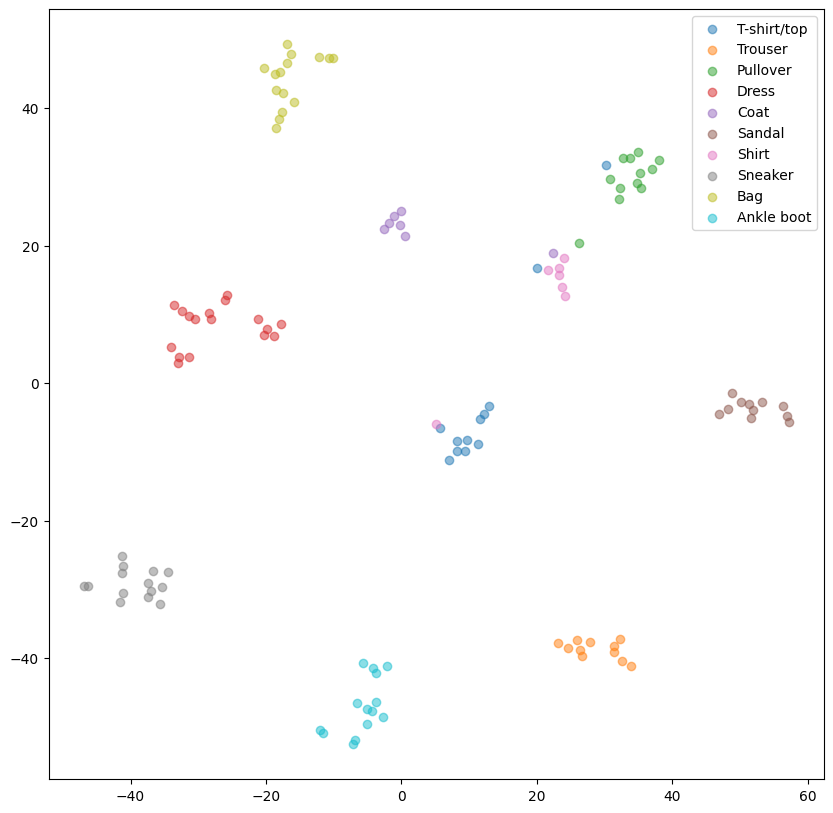

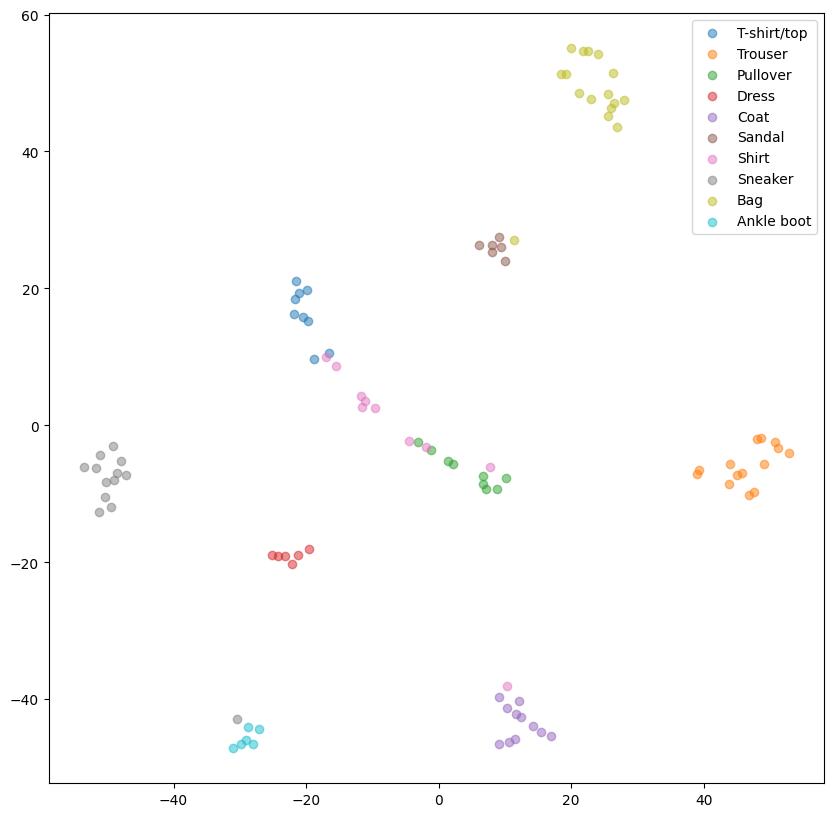

In [34]:
from sklearn.manifold import TSNE
train_embeddings, train_labels = get_all_embeddings(train_dataset, model)
train_embeddings = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(train_embeddings[::500].cpu())
plot_embeddings(train_embeddings, train_labels[::500].cpu()) #Use just the first 500 points of the training set


test_embeddings, test_labels = get_all_embeddings(test_dataset, model)
test_embeddings = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(test_embeddings[::100].cpu())
plot_embeddings(test_embeddings, test_labels[::100].cpu()) #Use just the first 100 points of the test set